In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import fsspec
import time
import json
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from carbonplan_trace.v1.glas_preprocess import preprocess
import carbonplan_trace.v1.glas_allometric_eq as allo
import carbonplan_trace.v1.utils as utils
from carbonplan_trace.v1.glas_height_metrics import get_all_height_metrics
from carbonplan_trace.utils import zarr_is_complete

In [3]:
from s3fs import S3FileSystem
from carbonplan_trace.v1.landsat_preprocess import access_credentials

access_key_id, secret_access_key = access_credentials()
fs = S3FileSystem(key=access_key_id, secret=secret_access_key)

In [4]:
import warnings

warnings.filterwarnings("ignore")

## local or remote cluster


In [ ]:
cluster_type = "remote"  # 'local'

In [ ]:
import dask
from dask.distributed import Client
from dask_gateway import Gateway

if cluster_type == "remote":
    gateway = Gateway()
    options = gateway.cluster_options()
    options.worker_cores = 1
    options.worker_memory = 120
    options.image = "carbonplan/trace-python-notebook:latest"
    cluster = gateway.new_cluster(cluster_options=options)
    cluster.adapt(minimum=1, maximum=10)
    client = cluster.get_client()
elif cluster_type == "local":
    client = Client(n_workers=2, threads_per_worker=1)
else:
    print("only cluster type of remote of local are supported")

In [ ]:
client

## Plotting example waveforms


In [5]:
import carbonplan_trace.v1.glas_height_metrics as h
from carbonplan_trace.v1.glas_preprocess import get_modeled_waveform

lat_tag = '50N'
lon_tag = '080W'
mapper = fsspec.get_mapper(f"s3://carbonplan-climatetrace/v1/preprocessed_lidar/{lat_tag}_{lon_tag}.zarr")
preprocessed = (
    xr.open_zarr(mapper)
    .stack(unique_index=("record_index", "shot_number"))
    .dropna(dim="unique_index", subset=["lat"])
)
# filtering of null values stored as the maximum number for the datatype
preprocessed = preprocessed.where(
    (preprocessed.rec_wf < 1e35).all(dim="rec_bin"), drop=True
)

distance_metrics = [
    "sig_begin_dist",
    "sig_end_dist",
    "ground_peak_dist",
    "adj_ground_peak_dist",
    "adj_ground_peak_dist_actual_wf",
]

for m in distance_metrics:
    preprocessed = h.get_dist_metric_value(preprocessed, m)

preprocessed['modeled_wf'] = get_modeled_waveform(preprocessed)

(31027470, 4)


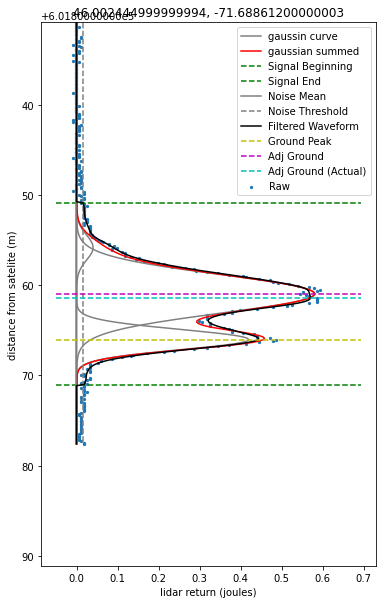

(496977874, 39)


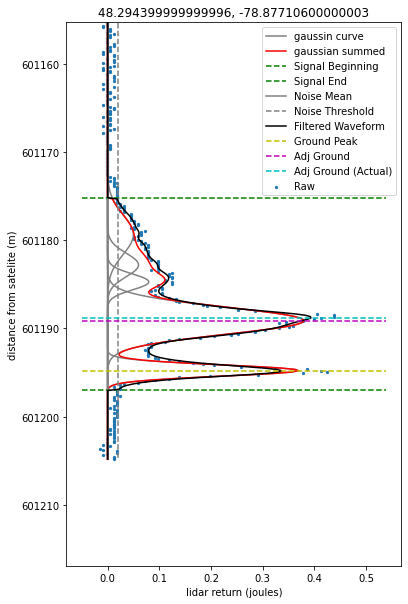

(289226891, 26)


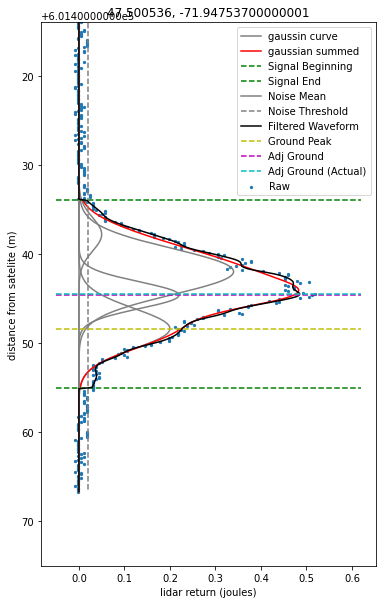

(750853213, 23)


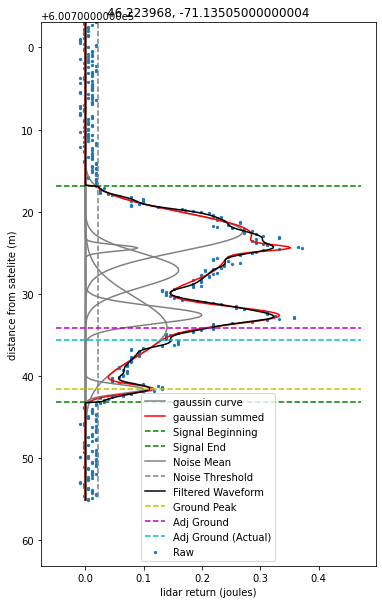

(539688162, 39)


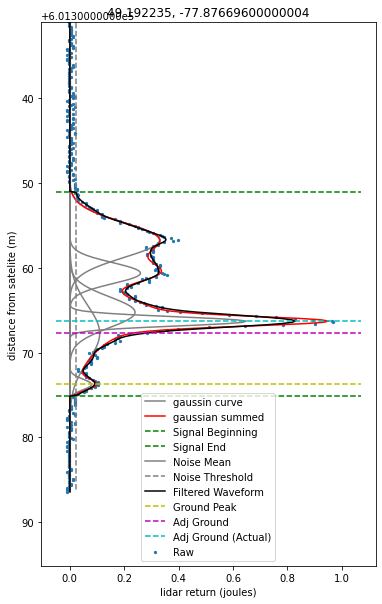

(22174610, 6)


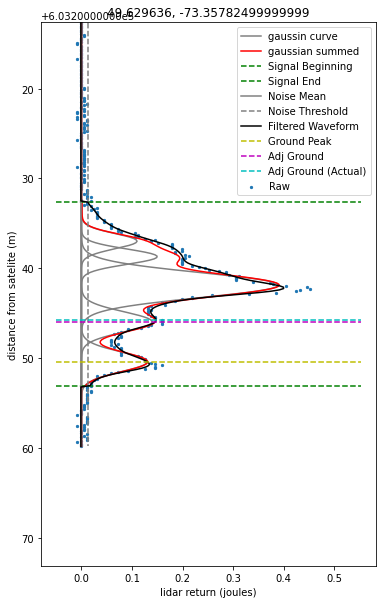

(451882893, 27)


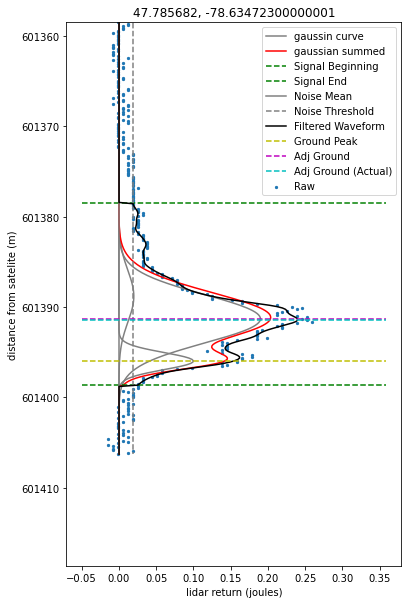

(938962765, 9)


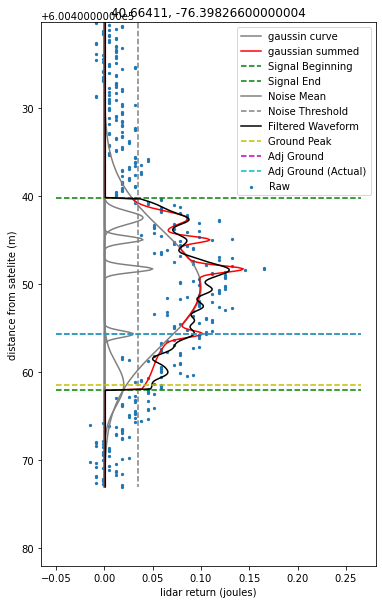

(614094756, 30)


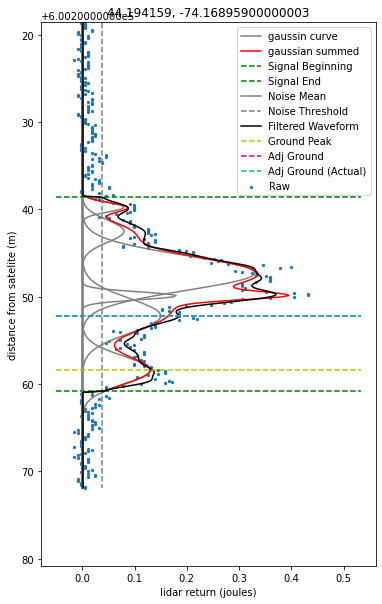

(939397710, 21)


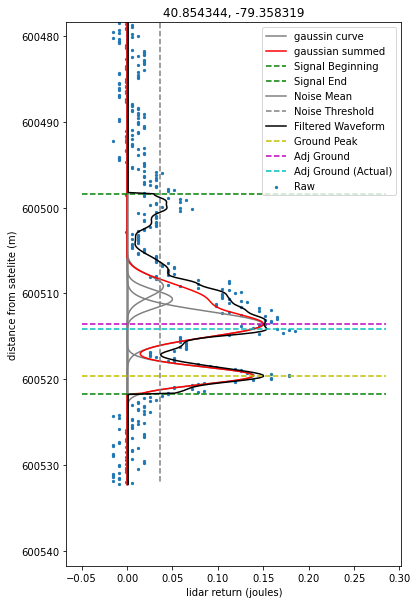

(912872843, 28)


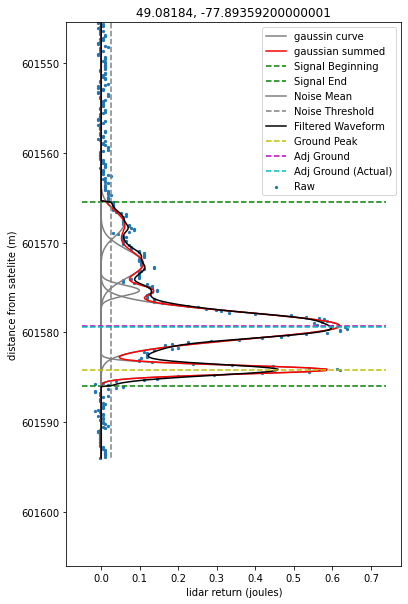

(536237987, 40)


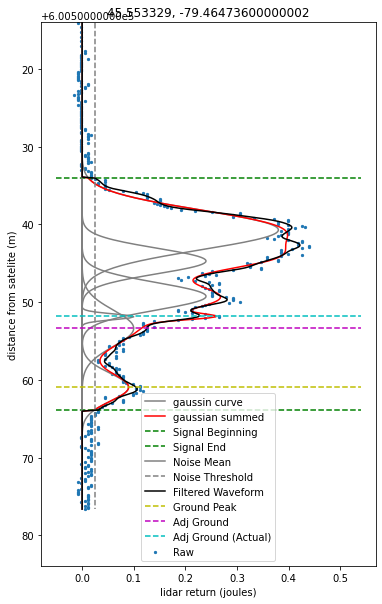

(337781184, 24)


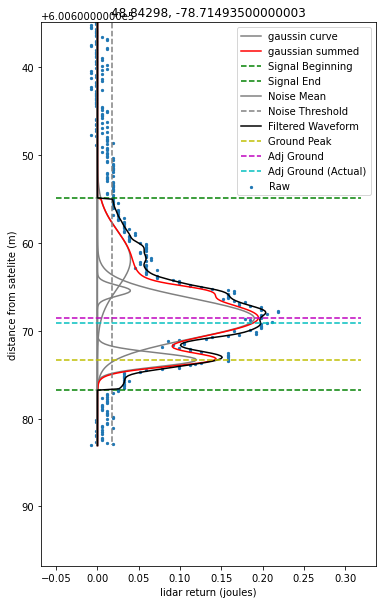

(380057066, 25)


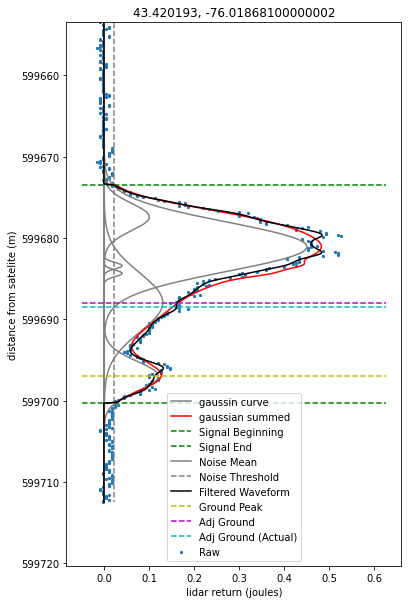

(33398620, 16)


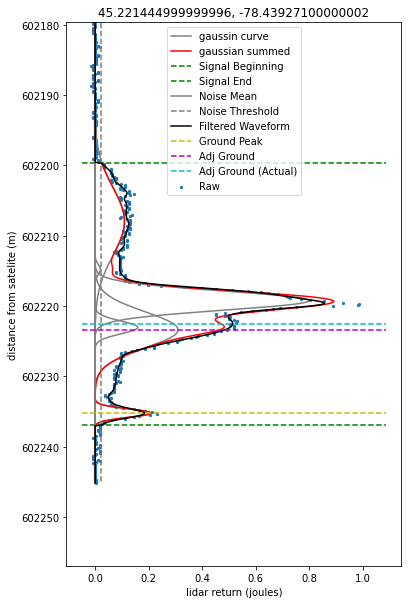

(224742144, 1)


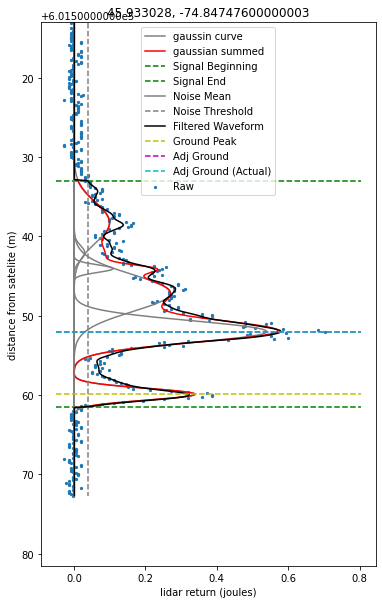

(122264671, 8)


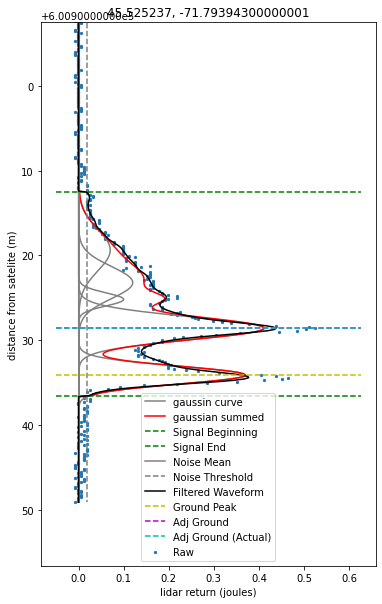

(125519121, 7)


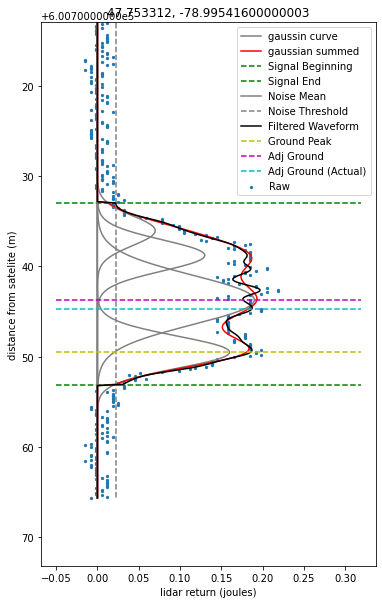

(910053348, 31)


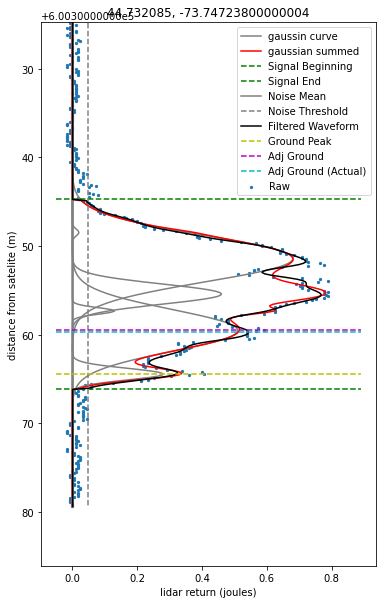

(540754017, 29)


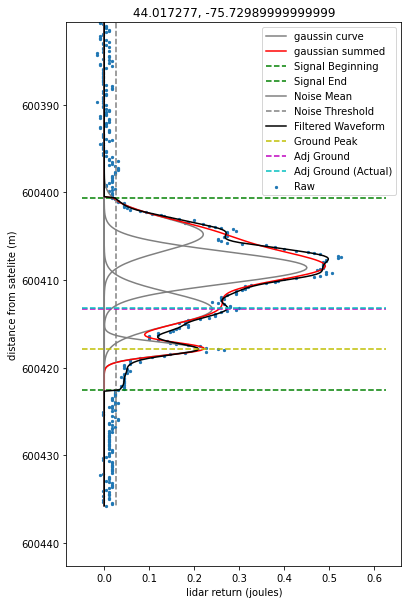

(224742464, 23)


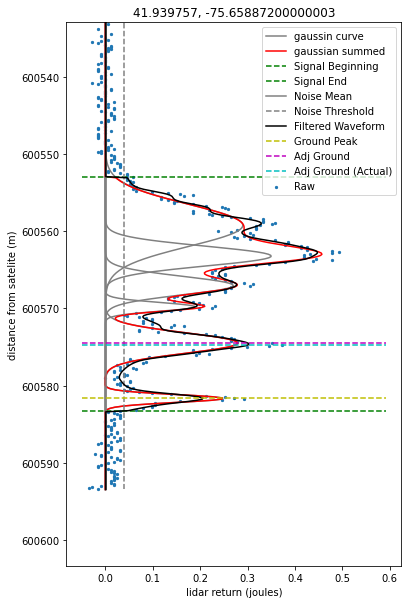

(228192934, 33)


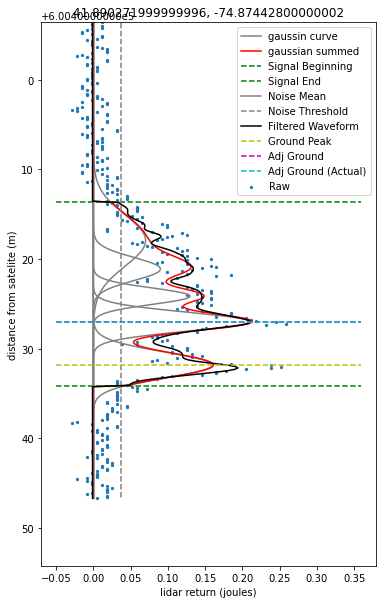

(118182836, 27)


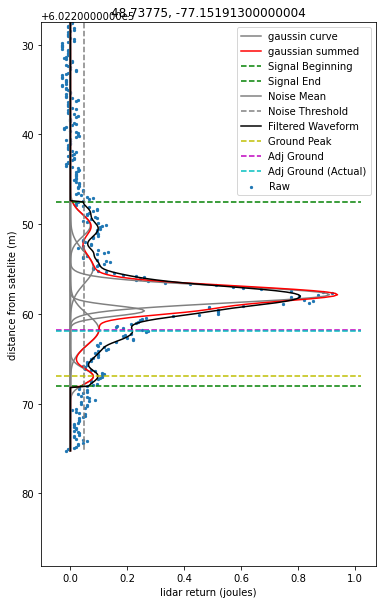

(122699626, 24)


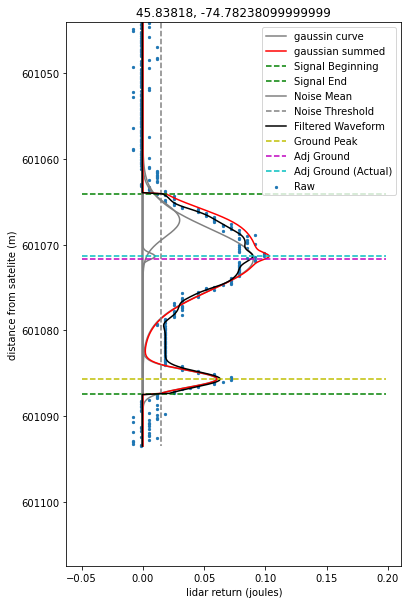

(126584636, 10)


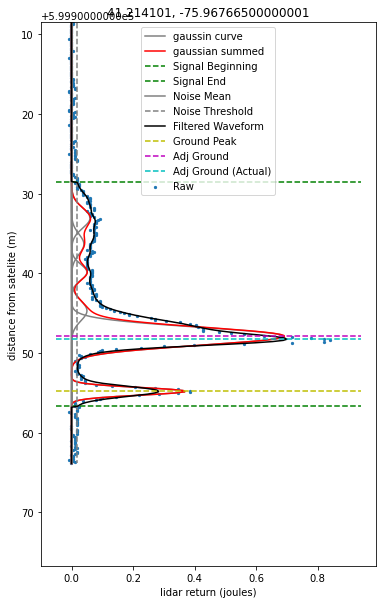

(443677193, 2)


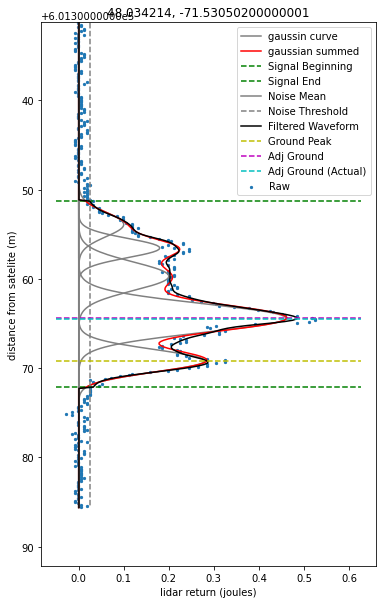

(24124545, 24)


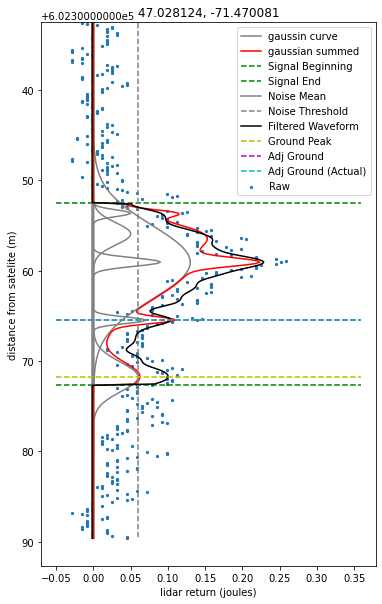

(288160941, 16)


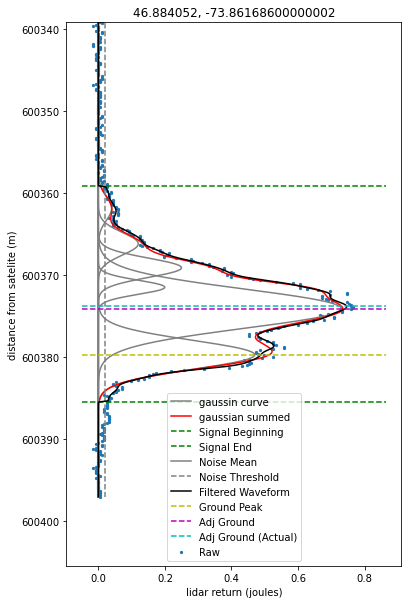

(189367537, 17)


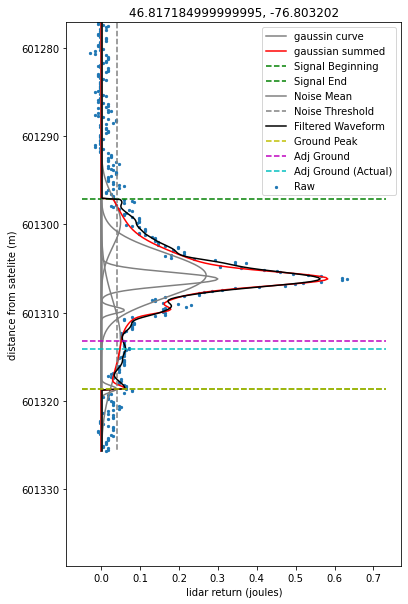

(384573211, 6)


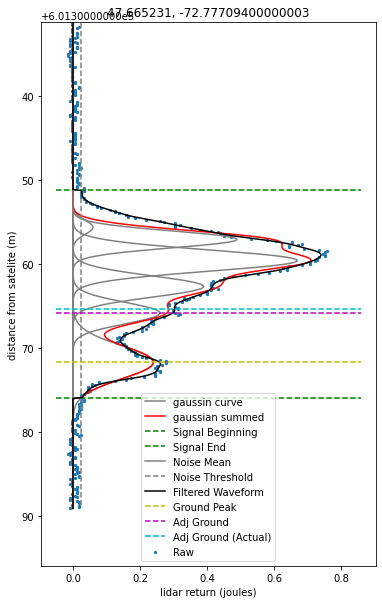

(35349345, 11)


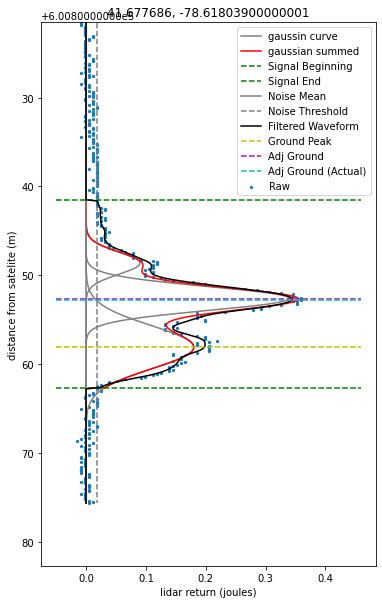

(224742464, 40)


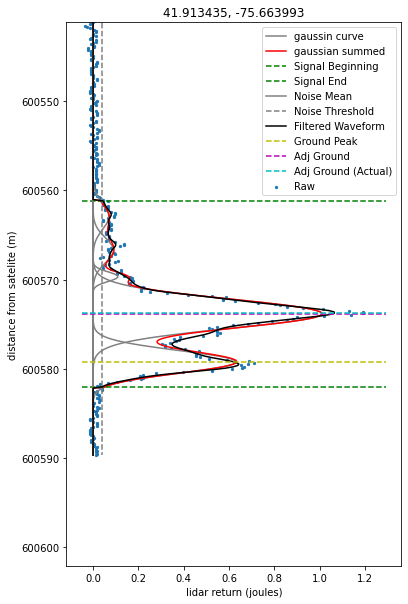

(278874971, 32)


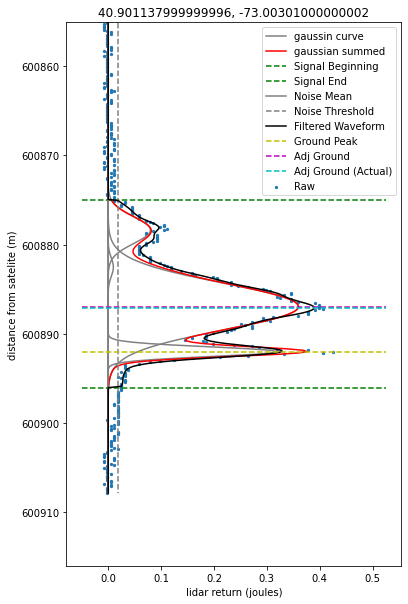

(547654892, 30)


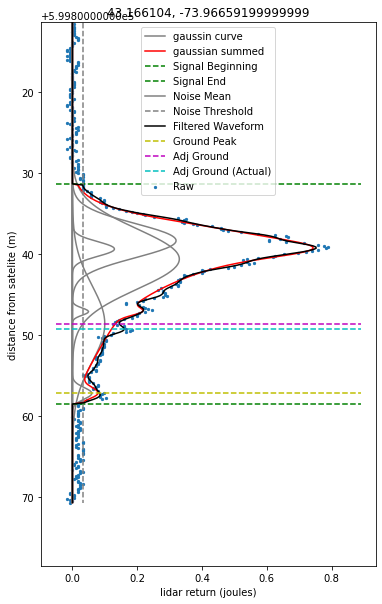

(446061598, 17)


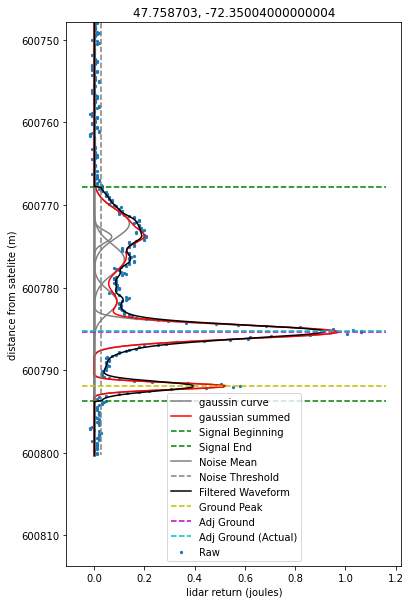

(756688528, 34)


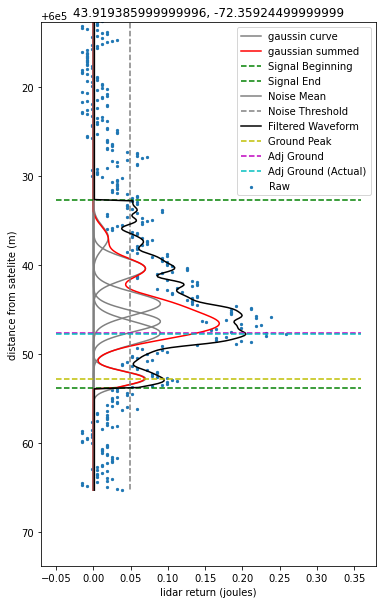

(288161126, 27)


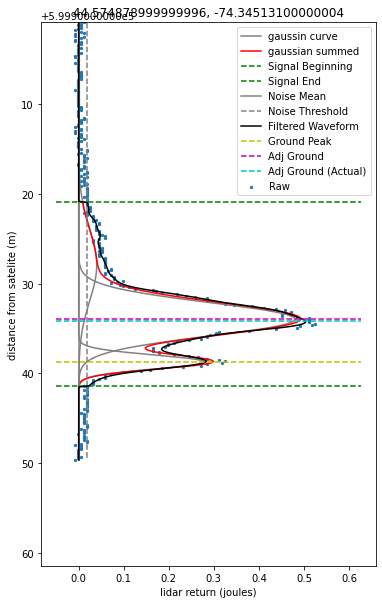

(547654892, 30)


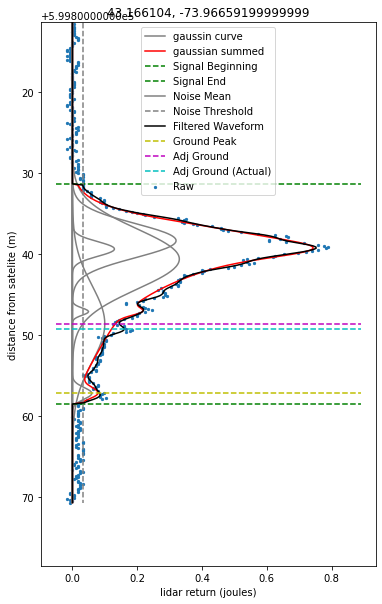

(137371416, 20)


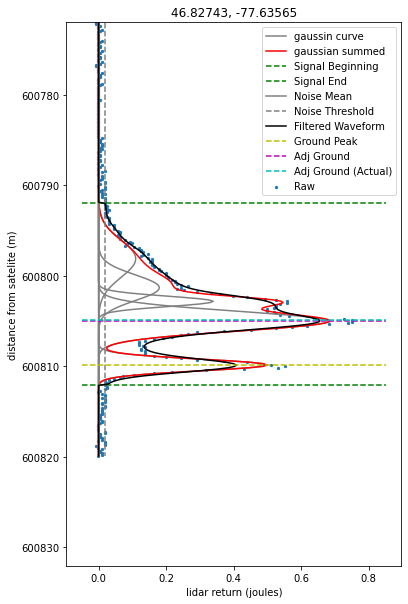

(281890916, 32)


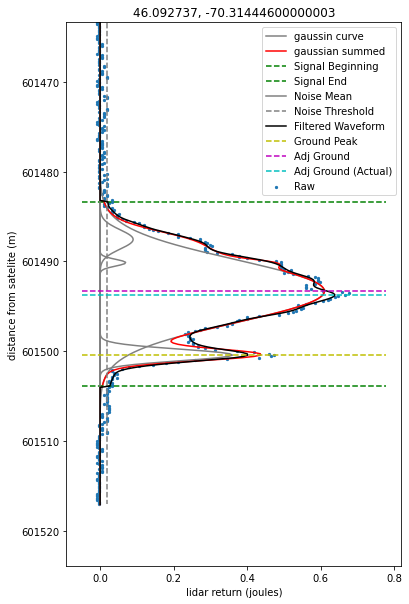

(764024164, 17)


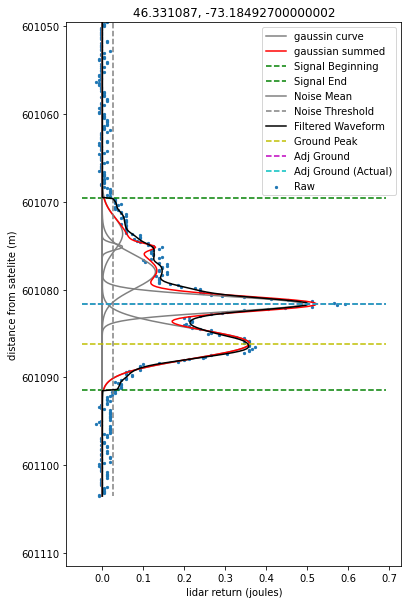

(284275366, 22)


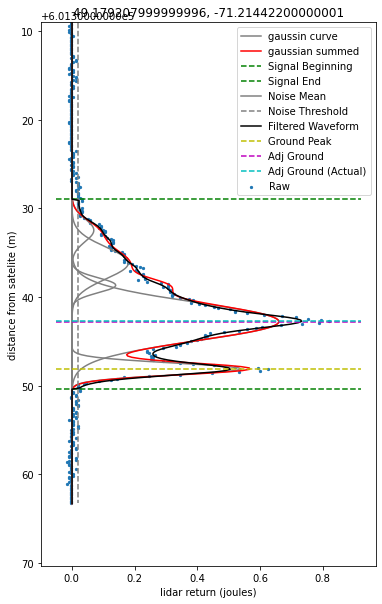

(225373254, 6)


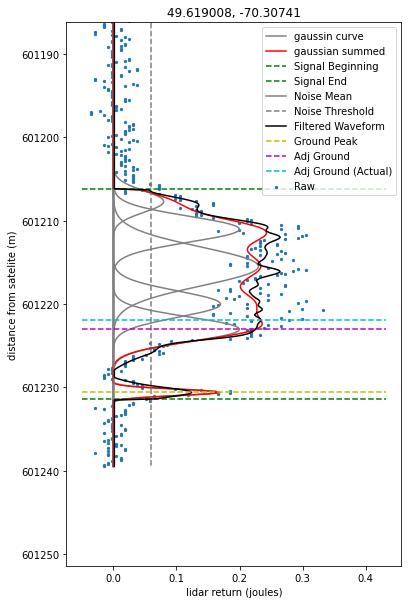

(31462675, 19)


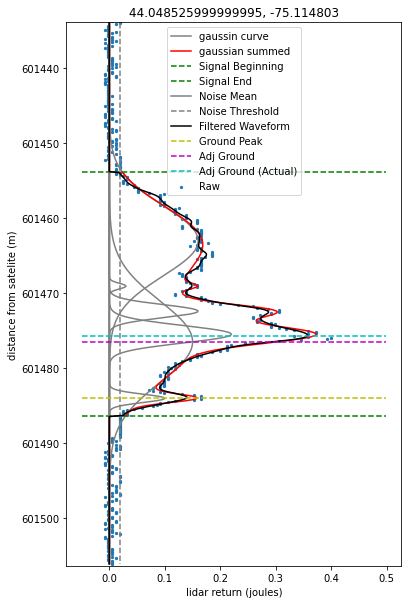

(278440386, 34)


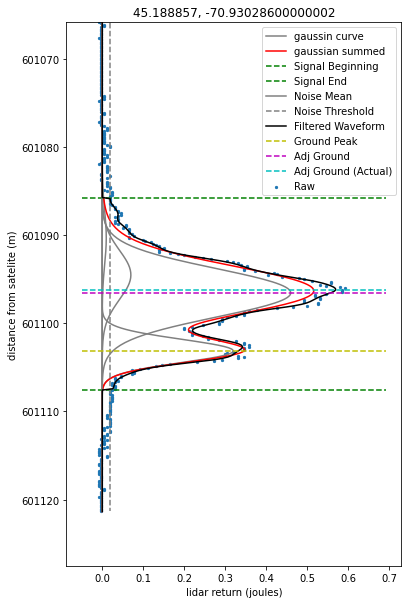

(454463613, 36)


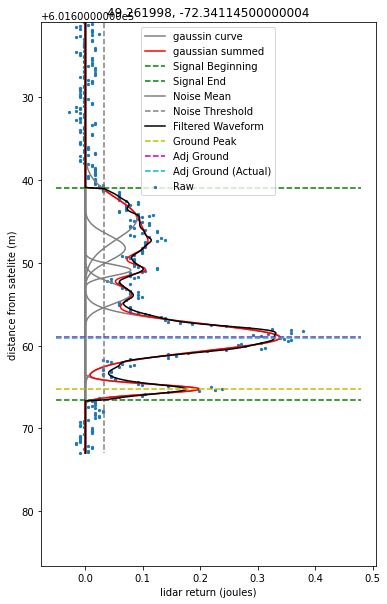

(388893511, 5)


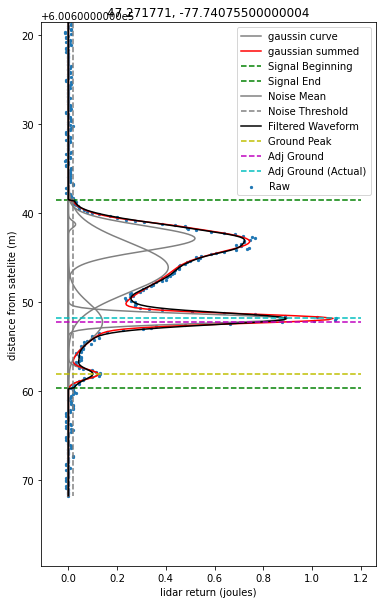

(606759216, 21)


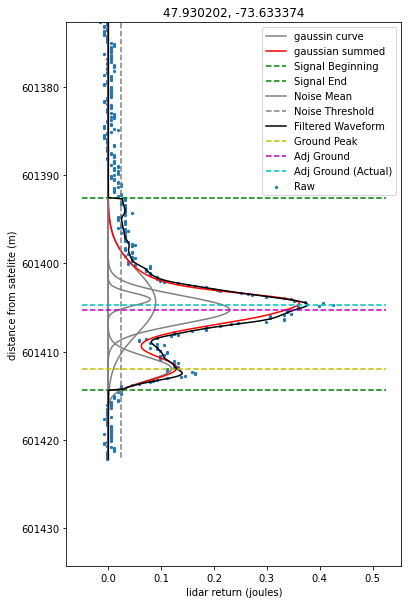

(218907084, 7)


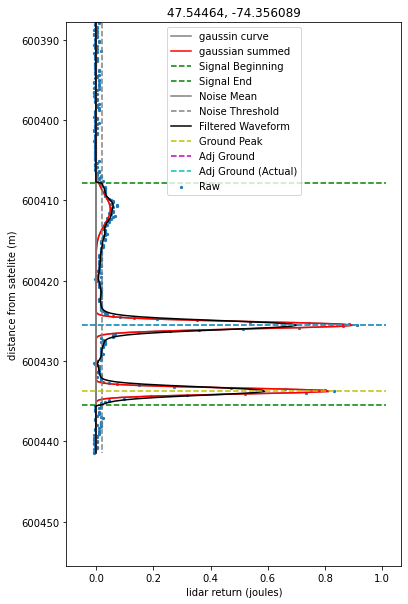

(822046142, 40)


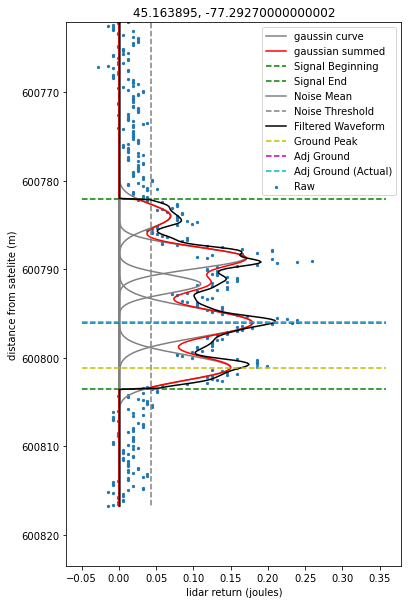

(229693139, 29)


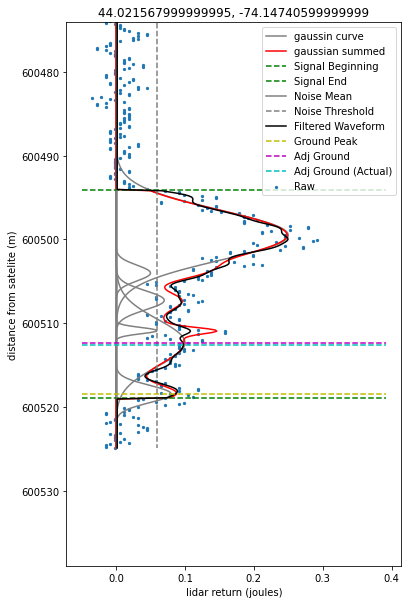

(341428054, 26)


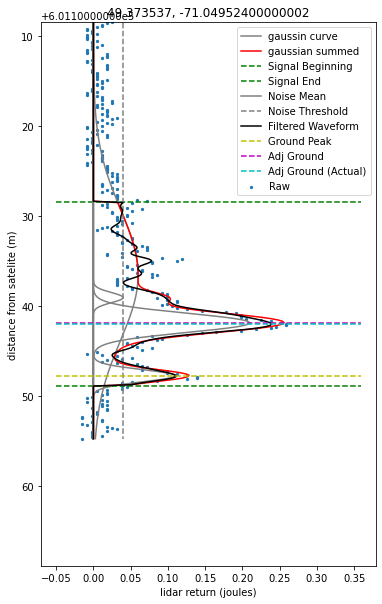

(750657113, 1)


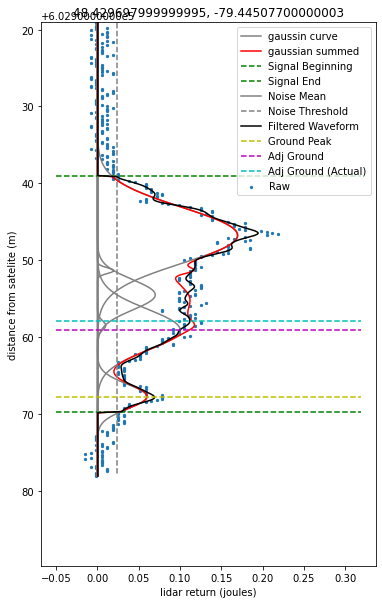

(750853188, 2)


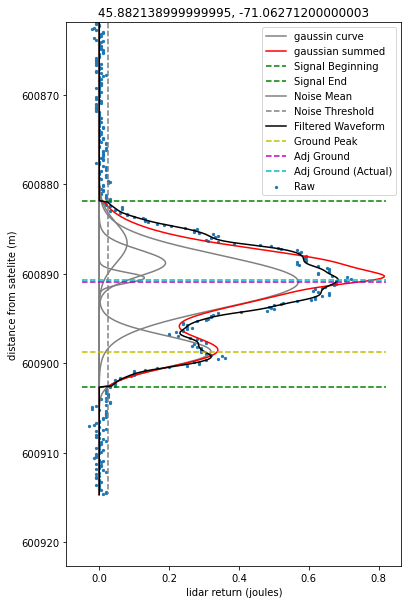

(115797526, 1)


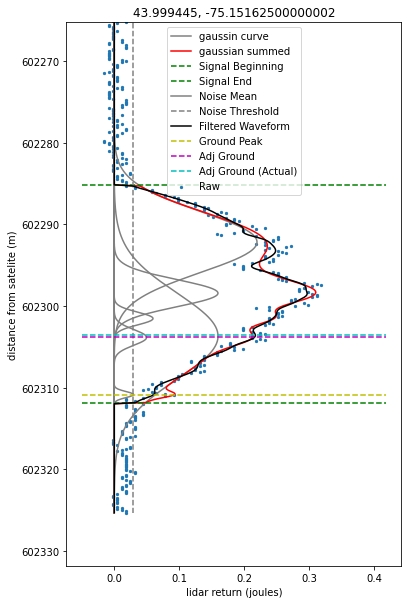

(126584636, 10)


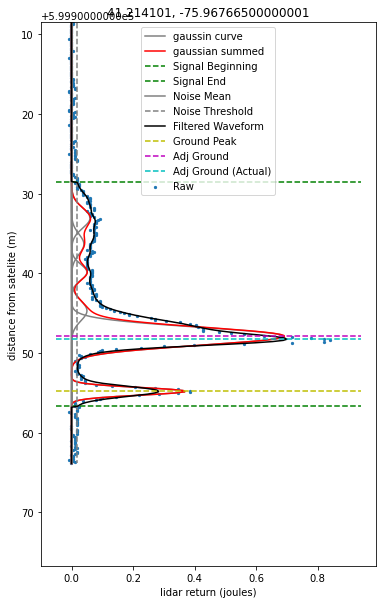

(823561202, 23)


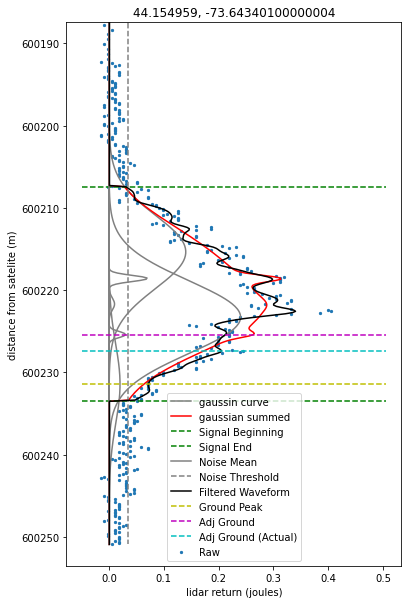

(117313296, 6)


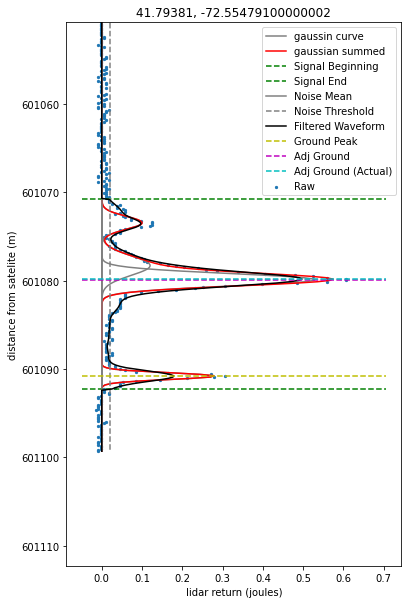

(385008176, 39)


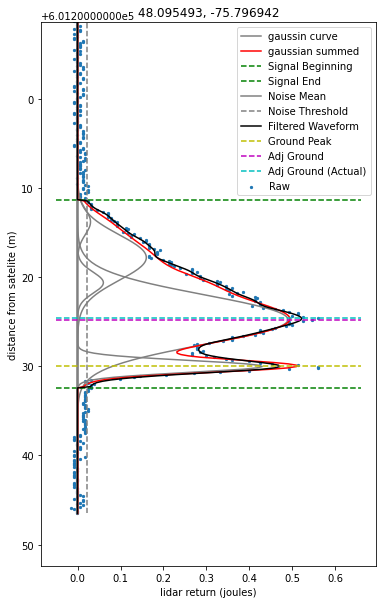

(222792374, 26)


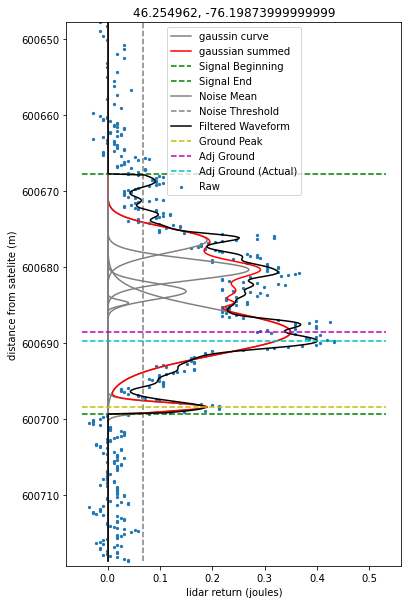

(289226891, 26)


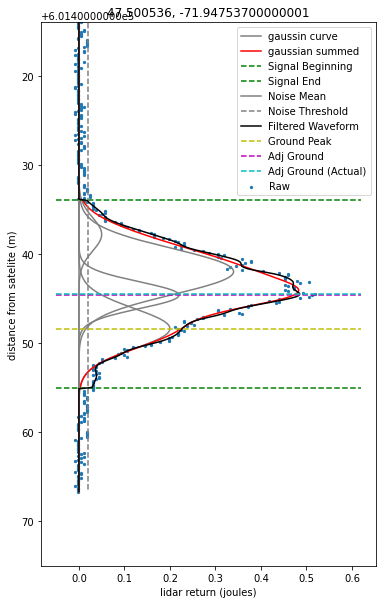

(388458056, 25)


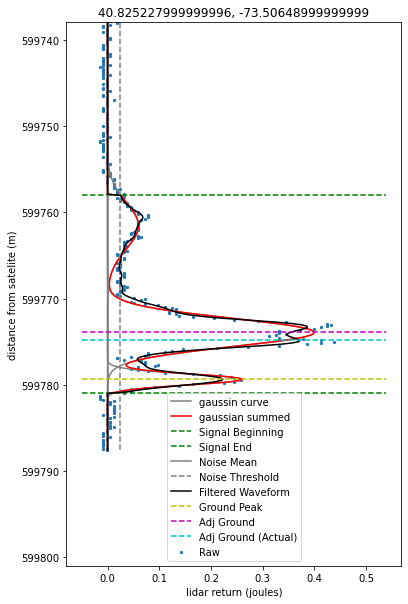

(348763834, 9)


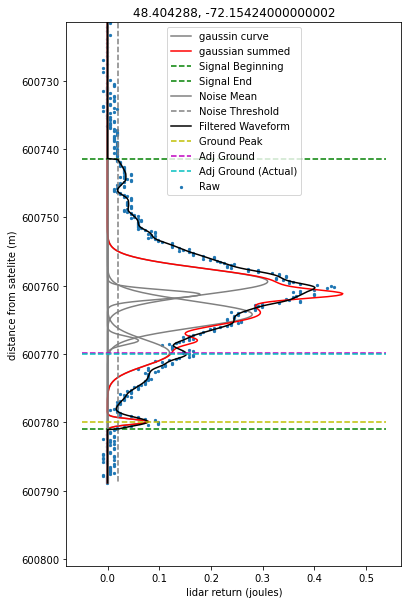

(278244726, 1)


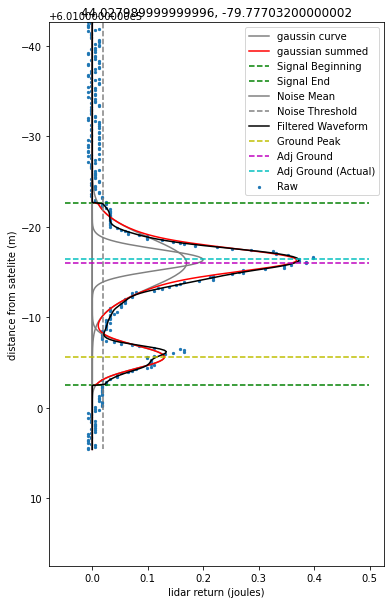

(28010920, 15)


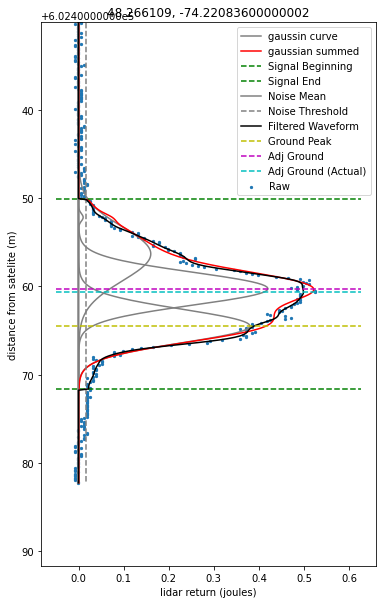

(221291549, 25)


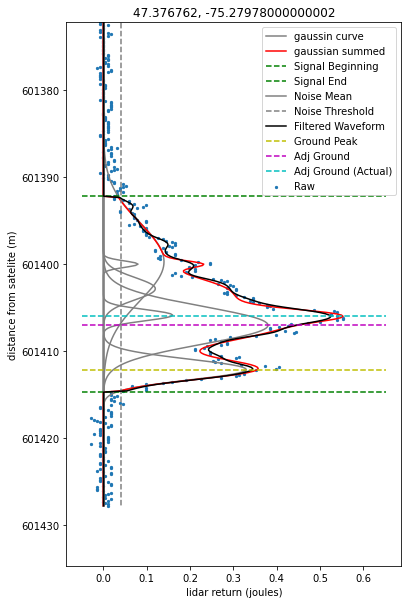

(383942331, 11)


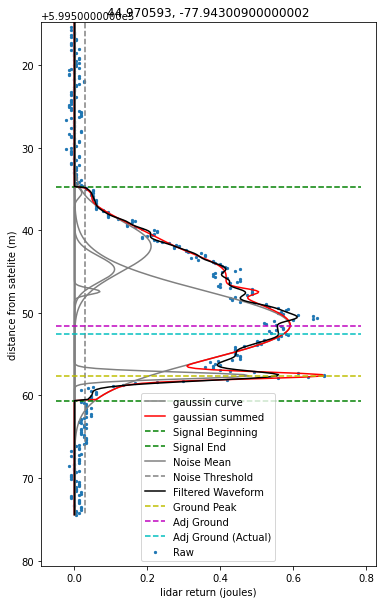

(122264986, 7)


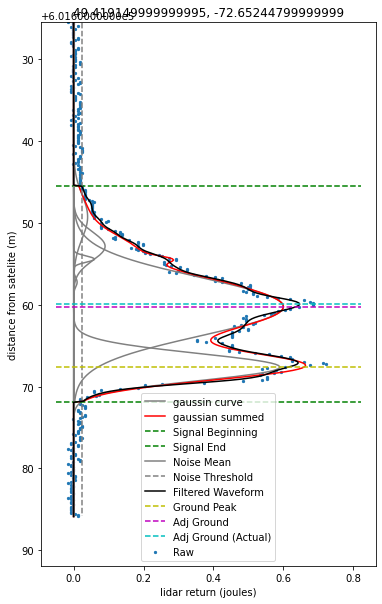

(383072231, 15)


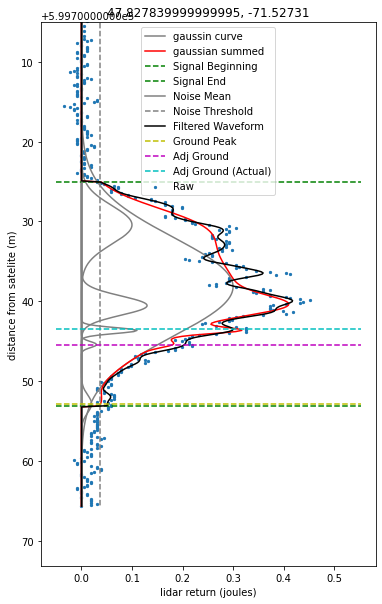

(549604702, 2)


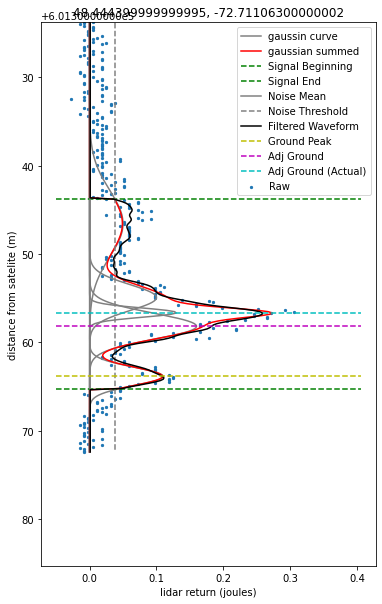

(378542031, 24)


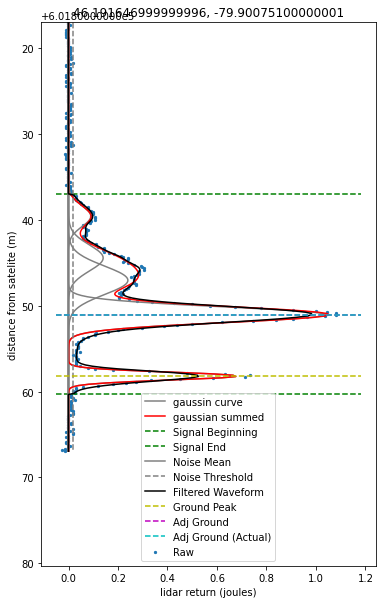

(540754047, 27)


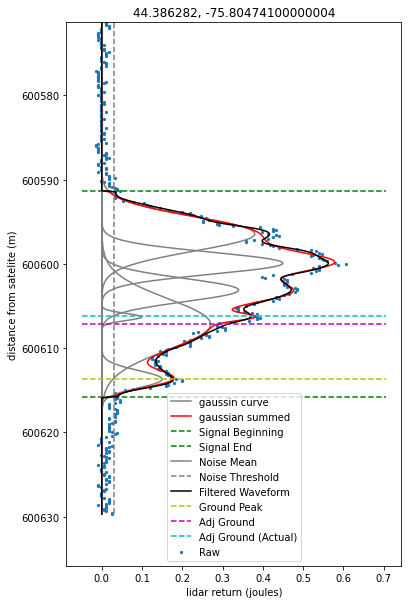

(755173498, 19)


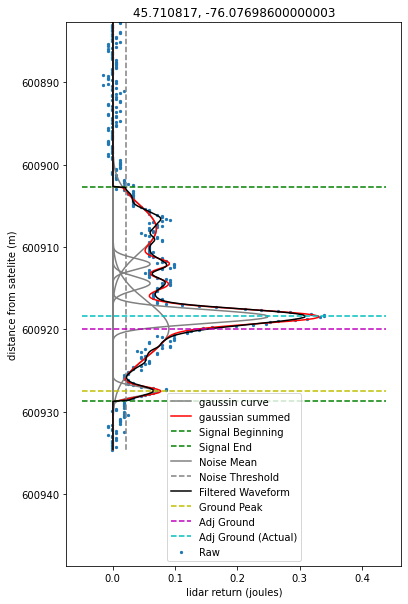

(115797341, 33)


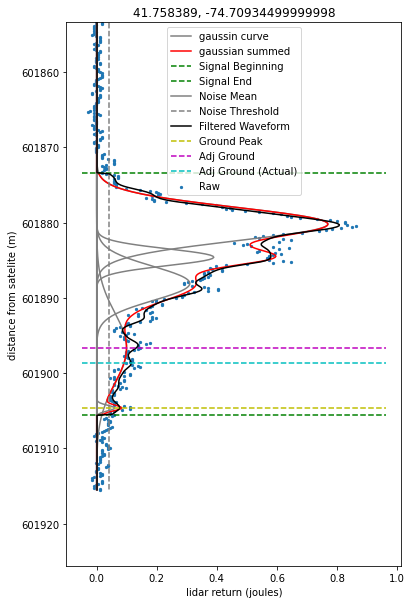

(537303797, 24)


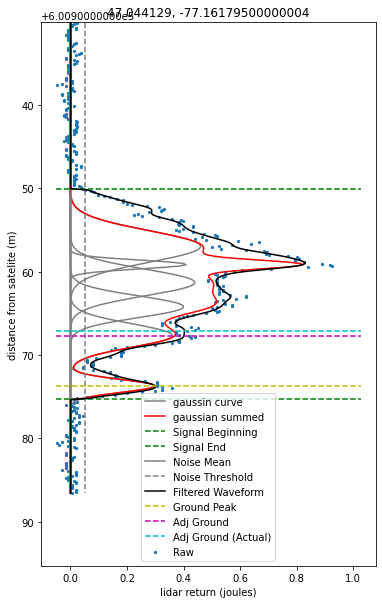

(121633956, 14)


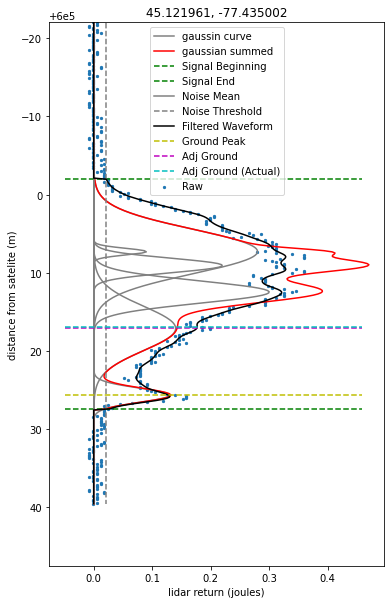

(608709036, 16)


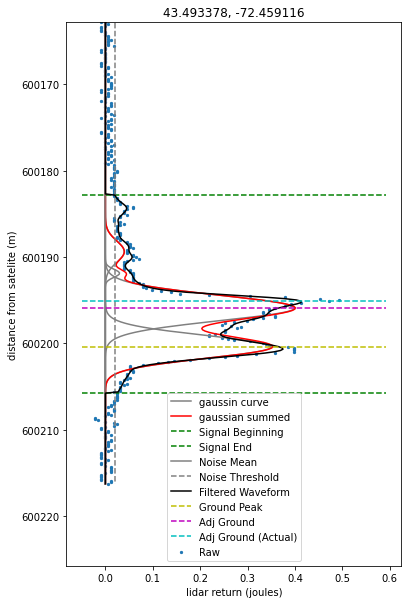

(547654892, 30)


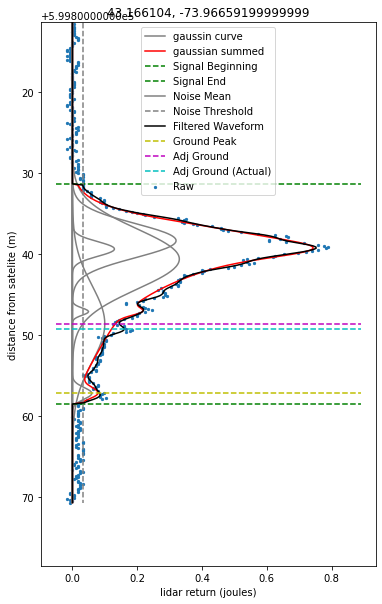

(606759216, 21)


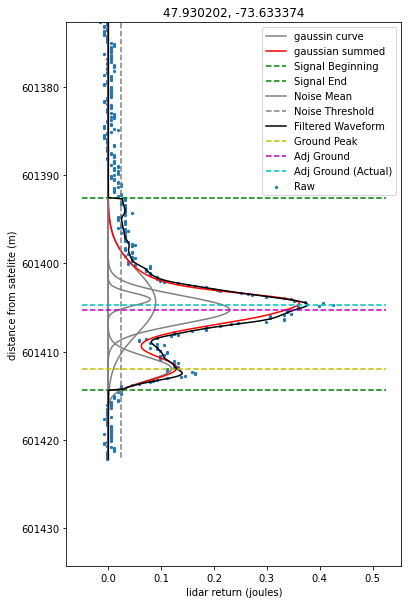

(29512515, 21)


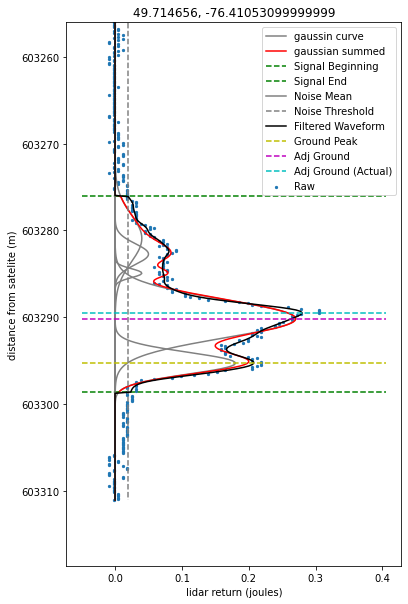

(381557751, 32)


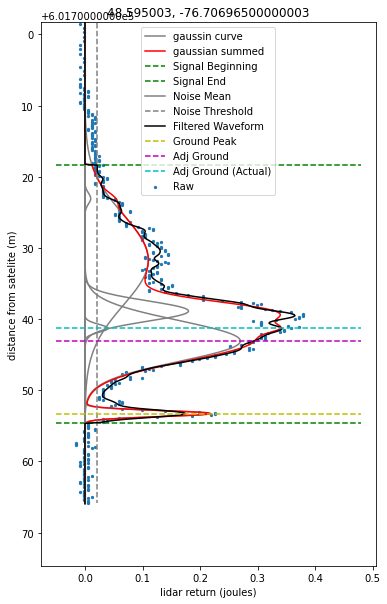

(750852988, 28)


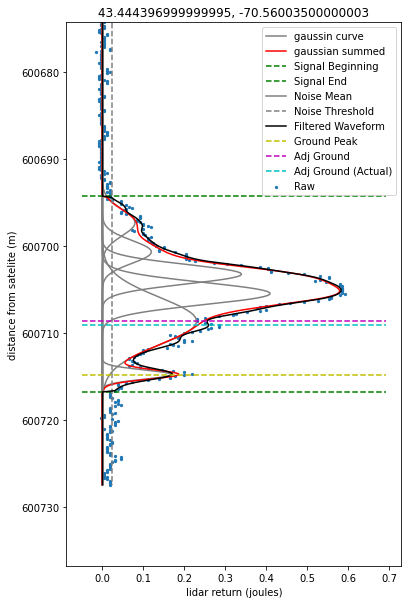

(227757439, 24)


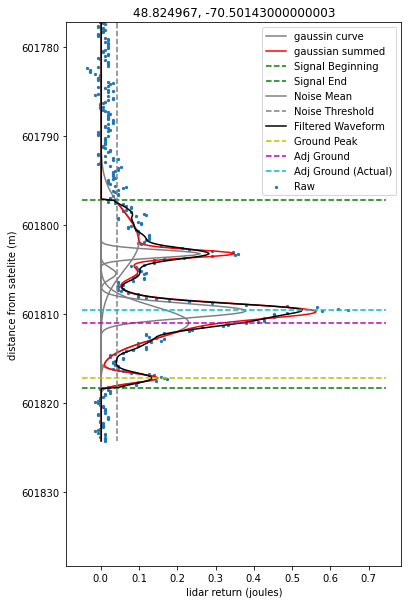

(390408341, 6)


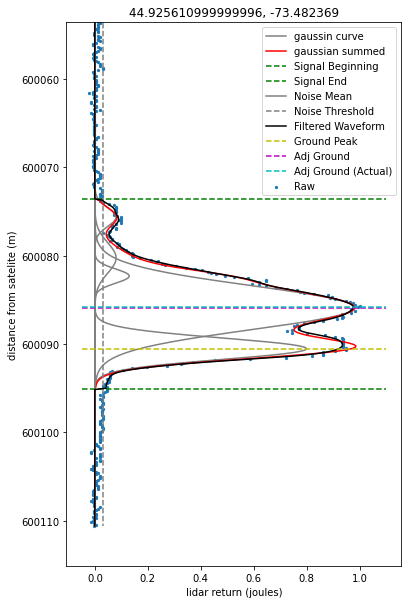

(278875136, 24)


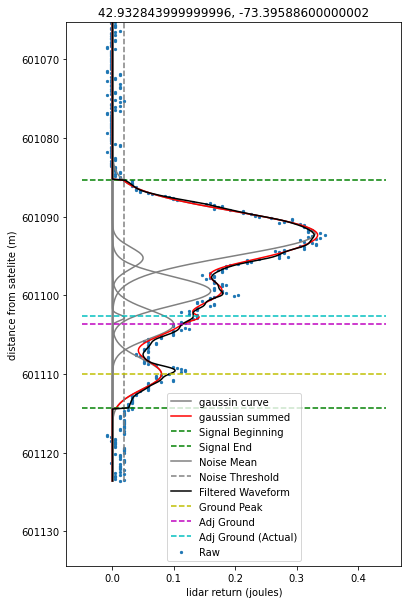

(232078369, 23)


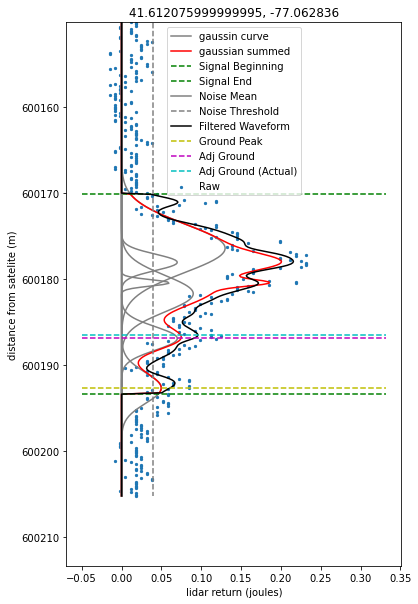

(281694946, 28)


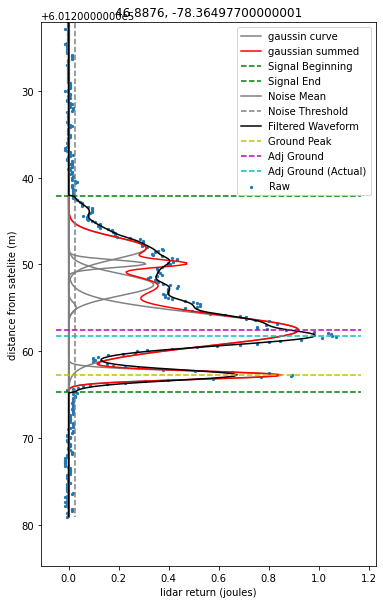

(115797526, 1)


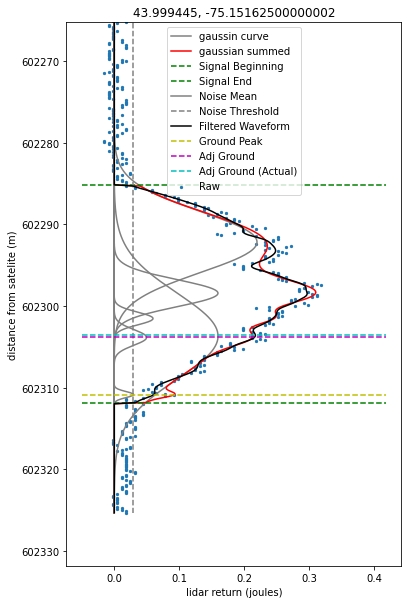

(545719557, 8)


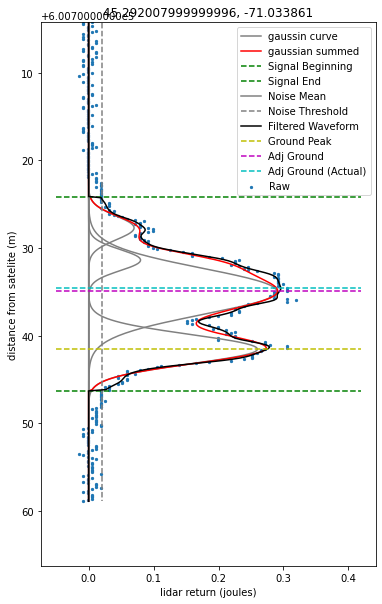

(117313161, 21)


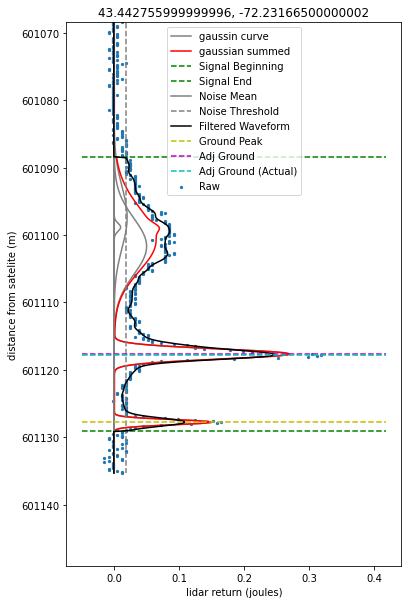

(22609335, 9)


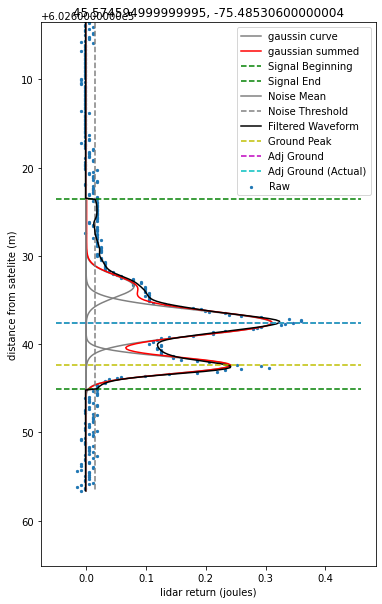

(35979835, 23)


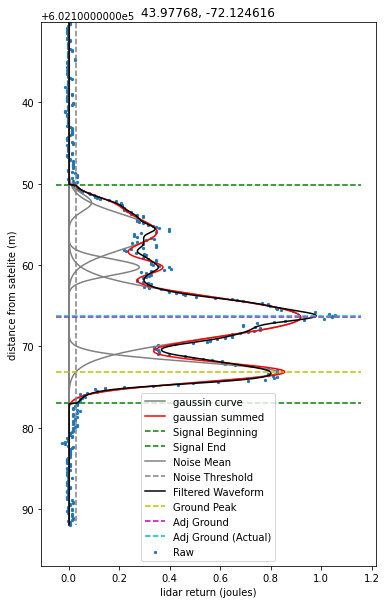

(182032162, 29)


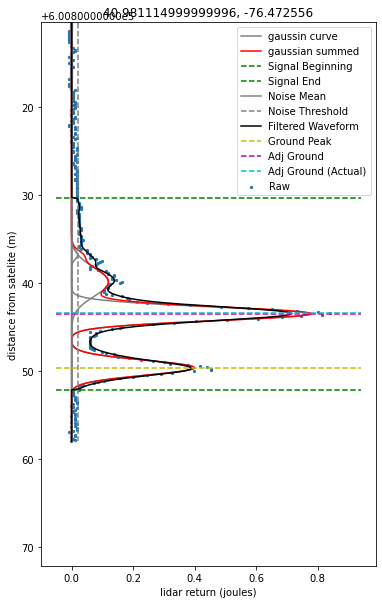

(32093825, 39)


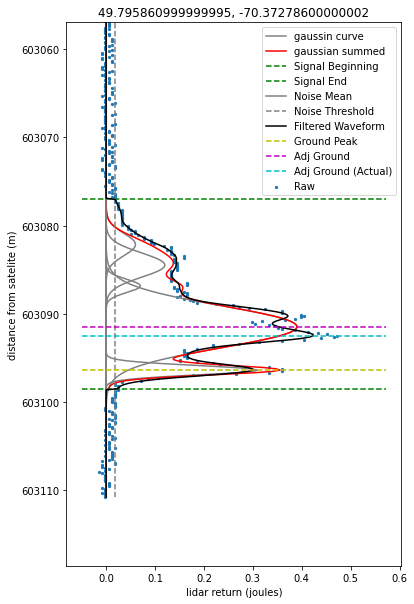

(122699816, 26)


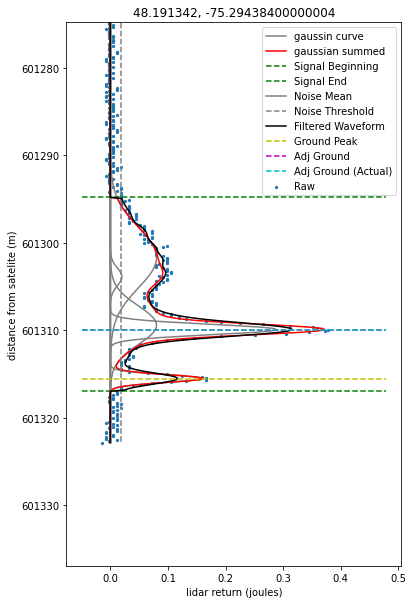

(183532157, 40)


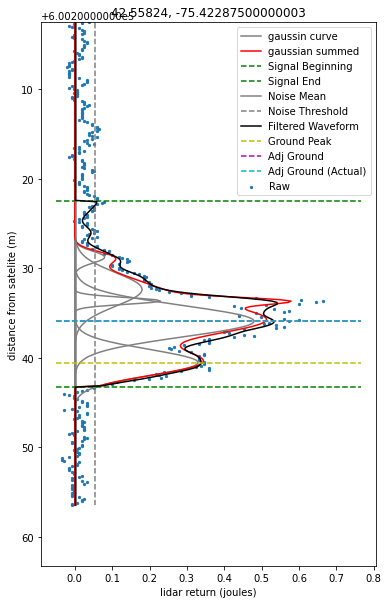

(376171691, 35)


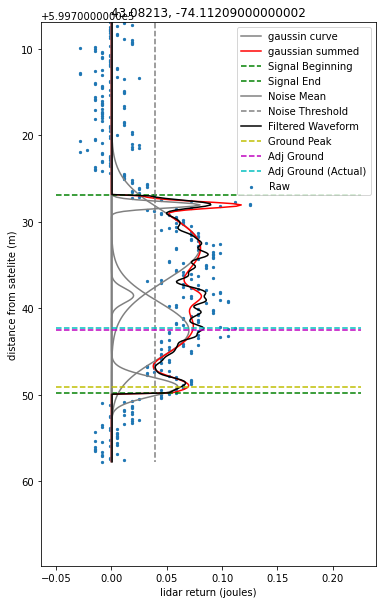

(121633766, 27)


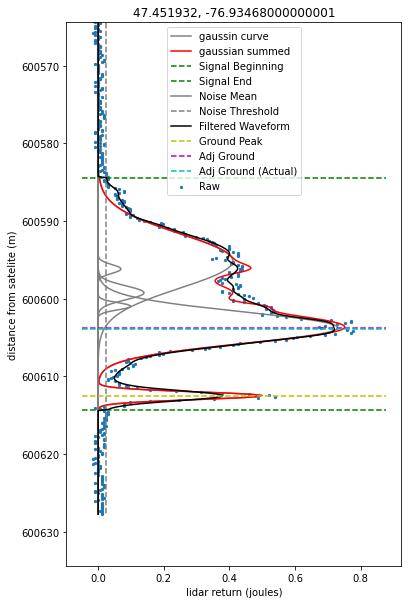

(344682289, 15)


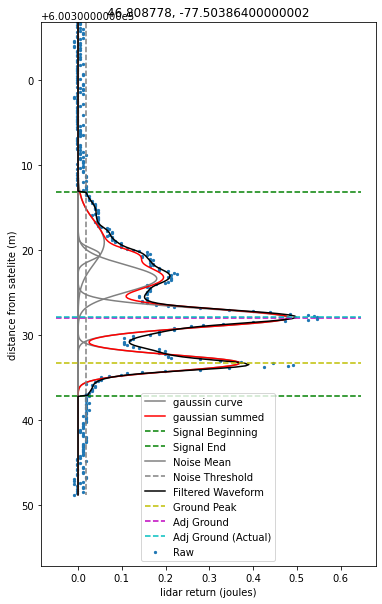

(122264671, 8)


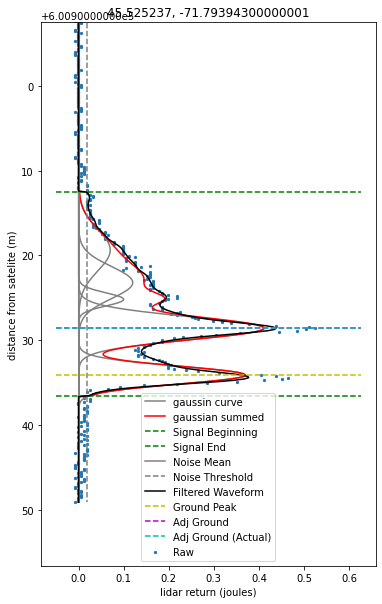

In [35]:
import random
for _ in range(10):
    ind = random.randint(0, preprocessed.dims['unique_index'])
    record = preprocessed.isel(unique_index=ind).load()
    print(f'{record.unique_index.values}')
    h.plot_shot(record)

In [53]:
def package_lidar_record_for_plotting(record):
    n_sig = 3.5
    
    ys = record.rec_wf_sample_dist.values
    raw = record.rec_wf.values 
    smoothed = (record.processed_wf + record.noise_mean).values

    d = {
        'raw': [[float(x), float(y)] for x, y in zip(raw, ys)],
        'smoothed': [[float(x), float(y)] for x, y in zip(smoothed, ys)],
        'signal_beginning': float(record.sig_begin_dist.values),
        'signal_end': float(record.sig_end_dist.values),
        'ground_peak': float(record.ground_peak_dist.values),
        'alternative_ground_peak': float(record.adj_ground_peak_dist_actual_wf.values),
        'noise_threshold': float((record.noise_mean + n_sig * record.noise_sd).values)
    }
    
    ind = record.unique_index.values.flatten()[0]
    with open(f'lidar_plot_data_{ind[0]}_{ind[1]}.json', 'w') as f:
        json.dump(d, f)
    
    return json.dumps(d)

In [54]:
# filtering criteria for cherry picking a lidar waveform to show as an example in the lidar blog post 
# we then look at randomly selected plots to pick the winner 

# preprocessed = preprocessed.where((preprocessed.num_gaussian_peaks > 2), drop=True)
# preprocessed = preprocessed.where(preprocessed.ground_peak_dist != preprocessed.adj_ground_peak_dist, drop=True)
# preprocessed = preprocessed.where((np.abs(preprocessed.adj_ground_peak_dist_actual_wf - preprocessed.adj_ground_peak_dist)<2), drop=True)

# preprocessed = preprocessed.where((preprocessed.sig_end_dist - preprocessed.sig_begin_dist > 20), drop=True)
# preprocessed = preprocessed.where(
#     (preprocessed.gaussian_amp.isel(n_gaussian_peaks=1) / preprocessed.gaussian_amp.isel(n_gaussian_peaks=0)) < 2,
#     drop=True)
# preprocessed = preprocessed.where(
#     (preprocessed.gaussian_amp.isel(n_gaussian_peaks=1) > preprocessed.gaussian_amp.isel(n_gaussian_peaks=0)),
#     drop=True)

# n_sig = 3.5

# preprocessed['noise_threshold'] = preprocessed.noise_mean + n_sig * preprocessed.noise_sd
# preprocessed = preprocessed.where((preprocessed.modeled_wf.max(dim='rec_bin') >= (preprocessed.noise_threshold * 3)), drop=True)

# preprocessed['height_to_ground'] = preprocessed.ground_peak_dist - preprocessed.sig_begin_dist
# preprocessed['diff_in_ground'] = preprocessed.ground_peak_dist - preprocessed.adj_ground_peak_dist

# preprocessed = preprocessed.where((preprocessed.diff_in_ground / preprocessed.height_to_ground) > 0.25, drop=True)


# record used for the lidar blog post has unique index of (22174610, 6) 
record = preprocessed.sel(unique_index=(22174610, 6))
package_lidar_record_for_plotting(record)

'{"raw": [[-0.0017040000529959798, 603259.7719501641], [-0.0017040000529959798, 603259.6220539351], [-0.0017040000529959798, 603259.4721577059], [-0.00837900023907423, 603259.322261477], [-0.0017040000529959798, 603259.172365248], [0.011645999737083912, 603259.022469019], [0.011645999737083912, 603258.87257279], [-0.0017040000529959798, 603258.722676561], [0.004970999900251627, 603258.5727803321], [0.011645999737083912, 603258.422884103], [-0.0017040000529959798, 603258.2729878741], [-0.0017040000529959798, 603258.1230916451], [0.004970999900251627, 603257.973195416], [0.004970999900251627, 603257.8232991871], [0.004970999900251627, 603257.673402958], [-0.00837900023907423, 603257.523506729], [0.004970999900251627, 603257.3736105], [0.011645999737083912, 603257.223714271], [0.011645999737083912, 603257.0738180421], [0.011645999737083912, 603256.923921813], [0.011645999737083912, 603256.7740255841], [0.011645999737083912, 603256.6241293551], [0.011645999737083912, 603256.474233126], [-0

## To run more tiles


In [ ]:
import dask


@dask.delayed
def process_one_tile(bounding_box, skip_existing, access_key_id, secret_access_key):
    min_lat, max_lat, min_lon, max_lon = bounding_box
    lat_tag, lon_tag = utils.get_lat_lon_tags_from_bounding_box(max_lat, min_lon)
    biomass_path = f"s3://carbonplan-climatetrace/v1/biomass/{lat_tag}_{lon_tag}.zarr"
    preprocessed_path = (
        f"s3://carbonplan-climatetrace/v1/preprocessed_lidar/{lat_tag}_{lon_tag}.zarr"
    )
    with dask.config.set(scheduler="single-threaded"):
        from s3fs import S3FileSystem

        fs = S3FileSystem(key=access_key_id, secret=secret_access_key)

        if skip_existing and fs.exists(biomass_path + "/.zmetadata"):
            return ("skipped", biomass_path)

        try:
            assert fs.exists(preprocessed_path + "/.zmetadata")
            mapper = fs.get_mapper(preprocessed_path)
            preprocessed = (
                xr.open_zarr(mapper)
                .stack(unique_index=("record_index", "shot_number"))
                .dropna(dim="unique_index", subset=["lat"])
            )
            # filtering of null values stored as the maximum number for the datatype
            preprocessed = preprocessed.where(
                (preprocessed.rec_wf < 1e35).all(dim="rec_bin"), drop=True
            )
            assert preprocessed.dims["unique_index"] > 0
        except:
            # read in data, this step takes about 5 mins
            data01 = utils.open_glah01_data()
            data14 = utils.open_glah14_data()

            # subset data to the bounding box
            sub14 = utils.subset_data_for_bounding_box(data14, min_lat, max_lat, min_lon, max_lon)
            sub01 = data01.where(data01.record_index.isin(sub14.record_index), drop=True)
            combined = sub14.merge(sub01, join="inner")

            if len(combined.record_index) == 0:
                return ("no data in lidar", biomass_path)

            # preprocess data and persist
            preprocessed = preprocess(combined, min_lat, max_lat, min_lon, max_lon)
            del combined, sub14, sub01

            if len(preprocessed.record_index) == 0:
                return ("no data after preprocess", biomass_path)

            preprocessed["datetime"] = preprocessed.datetime.astype("datetime64[ns]")

            preprocessed = preprocessed.unstack("unique_index")
            preprocessed = preprocessed.chunk({"record_index": 500, "shot_number": 40})

            mapper = fs.get_mapper(preprocessed_path)
            mapper.clear()
            for v in list(preprocessed.keys()):
                if "chunks" in preprocessed[v].encoding:
                    del preprocessed[v].encoding["chunks"]
            preprocessed.to_zarr(mapper, mode="w", consolidated=True)

        # calculate biomass
        with_biomass = allo.apply_allometric_equation(
            preprocessed, min_lat, max_lat, min_lon, max_lon
        )

        # saving output
        height_metrics = [
            "VH",
            "h25_Neigh",
            "h50_Neigh",
            "h75_Neigh",
            "h90_Neigh",
            "QMCH",
            "MeanH",
            "f_slope",
            "senergy",
        ]

        with_biomass = get_all_height_metrics(with_biomass, height_metrics).compute()
        variables = [
            "lat",
            "lon",
            "time",
            "biomass",
            "allometric_eq",
            "glas_elev",
            "ecoregion",
            "eosd",
            "nlcd",
            "igbp",
            "treecover2000_mean",
            "burned",
        ]

        with_biomass = with_biomass.unstack("unique_index")[variables + height_metrics]
        with_biomass = with_biomass.chunk({"record_index": 500, "shot_number": 40})
        mapper = fs.get_mapper(biomass_path)
        for v in list(with_biomass.keys()):
            if "chunks" in with_biomass[v].encoding:
                del with_biomass[v].encoding["chunks"]
        with_biomass.to_zarr(mapper, mode="w", consolidated=True)

        return ("processed", biomass_path)

In [ ]:
# run all tiles that doesn't exist in output yet


def get_list_of_mask_tiles(include=""):
    """
    Ecoregions mask is stored in 10 degree tiles, grab the filepaths
    """
    no_data_tiles = ["40N_070W", "30N_170W", "20N_120W", "00N_070E"]

    fs = S3FileSystem()
    mask_folder = "s3://carbonplan-climatetrace/intermediate/ecoregions_mask/"
    # fs.ls includes the parent folder itself, skip that link
    mask_paths = [tp for tp in fs.ls(mask_folder) if not tp.endswith("/") and include in tp]

    all_lat_lon_tags = [utils.get_lat_lon_tags_from_tile_path(tp) for tp in mask_paths]

    lat_lon_tags = []
    for lat, lon in all_lat_lon_tags:
        fn = f"{lat}_{lon}"
        output_path = f"s3://carbonplan-climatetrace/v1/biomass/{lat}_{lon}.zarr/.zmetadata"
        if not fs.exists(output_path) and not fn in no_data_tiles:
            lat_lon_tags.append((lat, lon))

    return lat_lon_tags


lat_lon_tags = get_list_of_mask_tiles()
# this should be in the order of min_lat, max_lat, min_lon, max_lon
bounding_boxes = [utils.parse_bounding_box_from_lat_lon_tags(lat, lon) for lat, lon in lat_lon_tags]

len(bounding_boxes)

In [ ]:
# run all tiles within the lat/lon box

# min_lat = -90
# max_lat = 90
# min_lon = -180
# max_lon = 180

# tiles = utils.find_tiles_for_bounding_box(
#     min_lat=min_lat, max_lat=max_lat, min_lon=min_lon, max_lon=max_lon
# )
# all_lat_lon_tags = [utils.get_lat_lon_tags_from_tile_path(tp) for tp in tiles]
# bounding_boxes = [
#     utils.parse_bounding_box_from_lat_lon_tags(lat, lon)
#     for lat, lon in all_lat_lon_tags
# ]
# len(bounding_boxes)

In [ ]:
skip_existing = True
tasks = []

for bounding_box in bounding_boxes:
    tasks.append(
        client.compute(
            process_one_tile(bounding_box, skip_existing, access_key_id, secret_access_key)
        )
    )

In [ ]:
results = dask.compute(tasks, retries=1)[0]
results

In [ ]:
for i, task in enumerate(tasks):
    if task.status != "pending":
        print(i)
        print(task.result())

In [ ]:
# for task in tasks:
#     task.cancel()

In [ ]:
mapper = fs.get_mapper("s3://carbonplan-climatetrace/v1/biomass/50N_120W.zarr")
ds = xr.open_zarr(mapper)

In [ ]:
ds.stack(unique_index=("record_index", "shot_number")).dropna(dim="unique_index", subset=["lat"])